# n-step TD Evaluation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [116]:
class RandomWalk:
    def __init__(self, num_states:int=7, start_state:int=None, reward1=0.0, reward2=1.0):
        self.current_state = None
        self.start_state = start_state if start_state is not None else num_states // 2
        self.num_states = num_states
        self.reward1 = reward1
        self.reward2 = reward2

    def reset(self):
        self.current_state = self.start_state
        return {"state":self.current_state}

    def is_terminated(self):
        if self.current_state in [0, self.num_states - 1]:
            return True
        return False

    def step(self, action:int):
        # 0 means left and 1 means right
        if self.current_state is None:
            raise ValueError("Please reset the environment first")
        if self.is_terminated():
            return {"state": self.current_state, "action":action, "reward": 0.0}
        if action not in [0, 1]:
            raise ValueError("Invalid action taken")
        
        if action == 0:
            self.current_state -= 1
        else:
            self.current_state += 1

        reward = 0.0
        if self.current_state == self.num_states - 1:
            reward = self.reward2
        elif self.current_state == 0:
            reward = self.reward1

        return {"state":self.current_state, "action":action, "reward":reward}

## n-step TD

In [132]:
def n_step_TD_Eval(
        V_init:np.ndarray, 
        n:int, 
        policy:np.ndarray, 
        env:RandomWalk, 
        episodes:int=100, 
        gamma:float=1.0, 
        alpha:float=0.6, 
        verbose:bool=False
    ):
    V = V_init.copy()
    history = [V.copy()]
    for episode in range(episodes):
        state = env.reset()['state']
        T = np.inf
        memory_st = np.zeros(shape=(n + 1,), dtype=np.int32)
        memory_rt = np.zeros(shape=(n + 1,), dtype=np.float32)

        time_step = 0
        memory_st[time_step % n] = state
        tau = None
        
        while tau != T-1:
            if time_step < T:
                action = np.random.choice([0, 1], p=policy[state])
                feedback = env.step(action)
                new_state = feedback['state']
                reward = feedback['reward']
                memory_rt[(time_step + 1) % (n + 1)] = reward
                memory_st[(time_step + 1) % (n + 1)] = new_state
                if env.is_terminated():
                    T = time_step + 1
            tau = time_step - n + 1
            if tau >= 0:
                Gt = 0
                for i in range(tau + 1, min(tau + n + 1, T + 1)):
                    Gt += gamma ** (i - tau - 1) * memory_rt[i % (n+1)]

                if tau + n < T:
                    Gt = Gt + gamma**n * V[memory_st[(tau + n) % (n + 1)]]

                tau_state = memory_st[tau % (n + 1)]
                V[tau_state] = V[tau_state] + alpha * (Gt - V[tau_state])
            time_step += 1
        history.append(V.copy())
        if verbose and episode % 1000 == 0:
            print(f'\rEpisode: {episode:<10}', end='')
    return V, history


## Evaluations and plots

## Experiment with $n$
We want to see how the value for $n$ will affect the RMS. We do the experiment once with the environment introduced in chapter 6 and then the modified environment in chapter 7, in which the number of states is changed to 19.

In [119]:
V_init = np.array([0, 1/2, 1/2, 1/2, 1/2, 1/2, 0], dtype=np.float32)
V_star = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 0], dtype=np.float32)
policy = np.ones(shape=(7, 2), dtype=np.float32) * 0.5
episodes = 100
ns = [1, 2, 3, 4, 5, 6, 7]
runs = 100

hist = {}

for n in ns:
    rms = np.zeros(shape=(episodes + 1,), dtype=np.float32)
    for run in tqdm(range(runs)):
        V, history = n_step_TD_Eval(V_init, n=n, policy=policy, env=RandomWalk(reward1=0, reward2=1), alpha=0.1, episodes=episodes)
        history = np.array(history)
        current_rms = np.sqrt(np.mean((history - V_star) ** 2, axis=-1))
        rms = rms + (1 / (run + 1)) * (current_rms - rms)
    hist[n] = rms

100%|██████████| 100/100 [00:02<00:00, 36.08it/s]


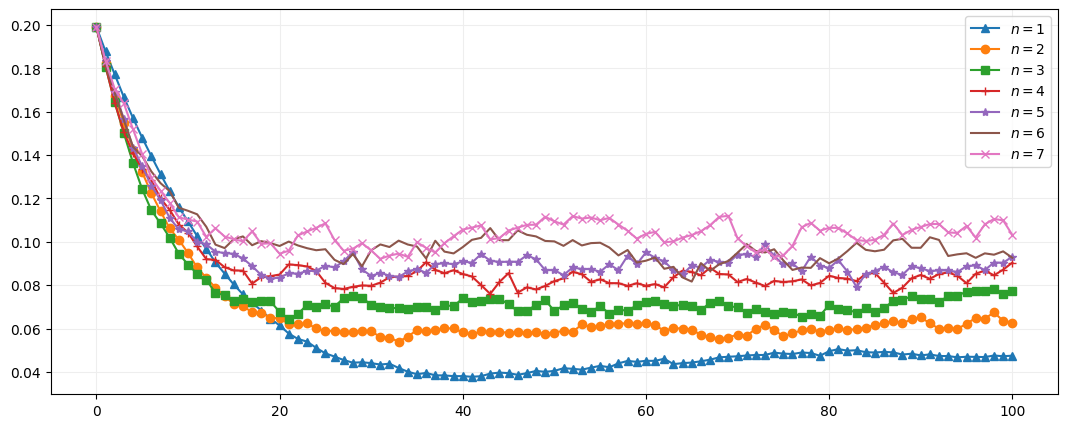

In [120]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 1, 1)
markers = ['x-', '^-', 'o-', 's-', '+-', '*-', '-']

for n, rms in hist.items():
    ax.plot(rms, markers[n % len(markers)], label=f'$n={n}$')
ax.grid(c='#eee')
ax.legend()

In [160]:
env = RandomWalk(num_states=19+2, reward1=-1, reward2=1) # +2 terminal states
V_init = np.zeros(shape=(21,), dtype=np.float32)
policy = np.ones(shape=(21, 2), dtype=np.float32) * 0.5

V_star = np.array([0] + [x + 0.1 for x in np.arange(-1.0, 0.9, 0.1)] + [0])

episodes = 10
ns = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
alphas = np.arange(0, 1.01, step=0.05)
runs = 100

hist = [[0 for _ in range(len(ns))] for _ in range(len(alphas))]

for a, alpha in enumerate(alphas):
    print(fr'$\alpha={alpha}$')
    for b, n in enumerate(ns):
        rms = 0
        for run in tqdm(range(runs)):
            V, history = n_step_TD_Eval(V_init, n=n, policy=policy, env=env, alpha=alpha, episodes=episodes)
            history = np.array(history)
            current_rms = np.sqrt(np.mean((history[:, 1:-1] - V_star[1:-1]) ** 2, axis=-1))
            current_rms = np.mean(current_rms)
            rms = rms + (1 / (run + 1)) * (current_rms - rms)
        
        hist[a][b] = rms

hist = np.array(hist)

$\alpha=0.0$


100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


$\alpha=0.05$


100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


$\alpha=0.1$


100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


$\alpha=0.15000000000000002$


100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


$\alpha=0.2$


100%|██████████| 100/100 [00:05<00:00, 19.00it/s]


$\alpha=0.25$


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


$\alpha=0.30000000000000004$


100%|██████████| 100/100 [00:05<00:00, 18.90it/s]


$\alpha=0.35000000000000003$


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


$\alpha=0.4$


100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


$\alpha=0.45$


100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


$\alpha=0.5$


100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


$\alpha=0.55$


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


$\alpha=0.6000000000000001$


100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


$\alpha=0.65$


100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


$\alpha=0.7000000000000001$


100%|██████████| 100/100 [00:04<00:00, 20.16it/s]


$\alpha=0.75$


100%|██████████| 100/100 [00:05<00:00, 19.99it/s]


$\alpha=0.8$


100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


$\alpha=0.8500000000000001$


100%|██████████| 100/100 [00:05<00:00, 19.62it/s]


$\alpha=0.9$


100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


$\alpha=0.9500000000000001$


100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


$\alpha=1.0$


100%|██████████| 100/100 [00:05<00:00, 19.66it/s]


(0.25, 0.55)

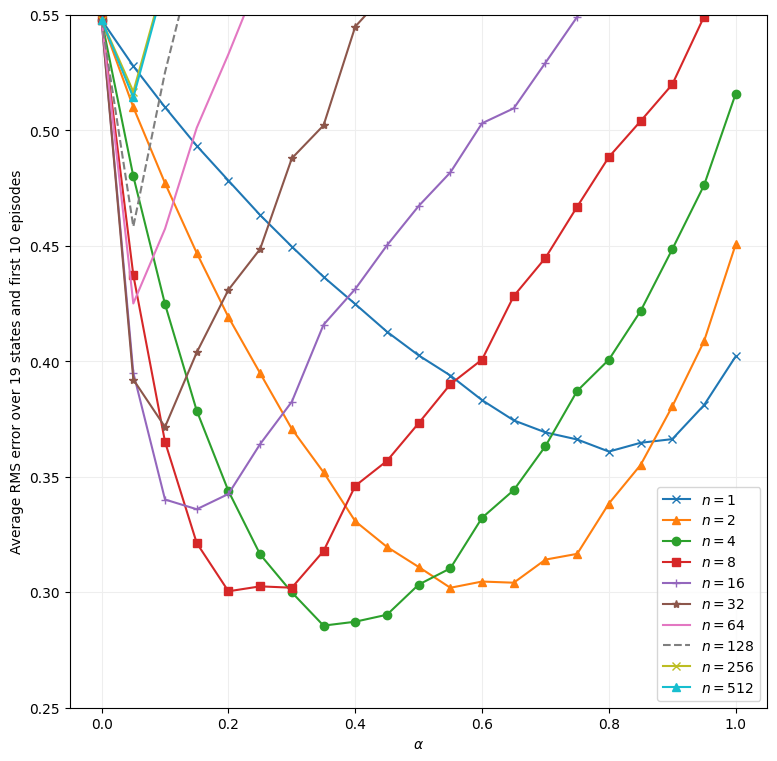

In [165]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(1, 1, 1)
markers = ['x-', '^-', 'o-', 's-', '+-', '*-', '-', '--']

for n in range(len(ns)):
    ax.plot(alphas, hist[:, n], markers[n % len(markers)], label=f'$n={ns[n]}$')
ax.grid(c='#eee')
ax.legend()
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Average RMS error over 19 states and first 10 episodes")
ax.set_ylim([0.25, 0.55])